# import and install all Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# Data load

In [2]:
root_path = 'C:/Users/HA Traders/Downloads/coinsdata/coin4.csv'


# btc_input_df = pd.read_csv(root_path, nrows=500)
btc_input_df = pd.read_csv(root_path,sep='\t',encoding='utf-16')
btc_input_df.tail()

,Time,BTC _Price_USD
4761,7/31/2023,29219.82019
4762,8/1/2023,29499.58754
4763,8/2/2023,29143.15196
4764,8/3/2023,29192.34486
4765,8/4/2023,29057.25324


# Data Minning AND Preprocessing

In [3]:
btc_input_df.shape

(4766, 2)

In [4]:
btc_input_df.describe()

,BTC _Price_USD
count,4766.000000
mean,9399.397689
std,14655.541937
min,0.050541
25%,181.343918
50%,985.142265
75%,10660.566755
max,67541.755510


In [5]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4766 entries, 0 to 4765
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time            4766 non-null   object 
 1   BTC _Price_USD  4766 non-null   float64
dtypes: float64(1), object(1)
memory usage: 74.6+ KB


In [6]:
btc_input_df_datetype = btc_input_df.astype({'Time': 'datetime64'})

In [7]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4766 entries, 0 to 4765
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time            4766 non-null   datetime64[ns]
 1   BTC _Price_USD  4766 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 74.6 KB


In [8]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

Null Values: 0
If any NA values: False


# Data Visaulizing

<Axes: title={'center': 'Bitcoin Weighted Price'}, xlabel='Time'>

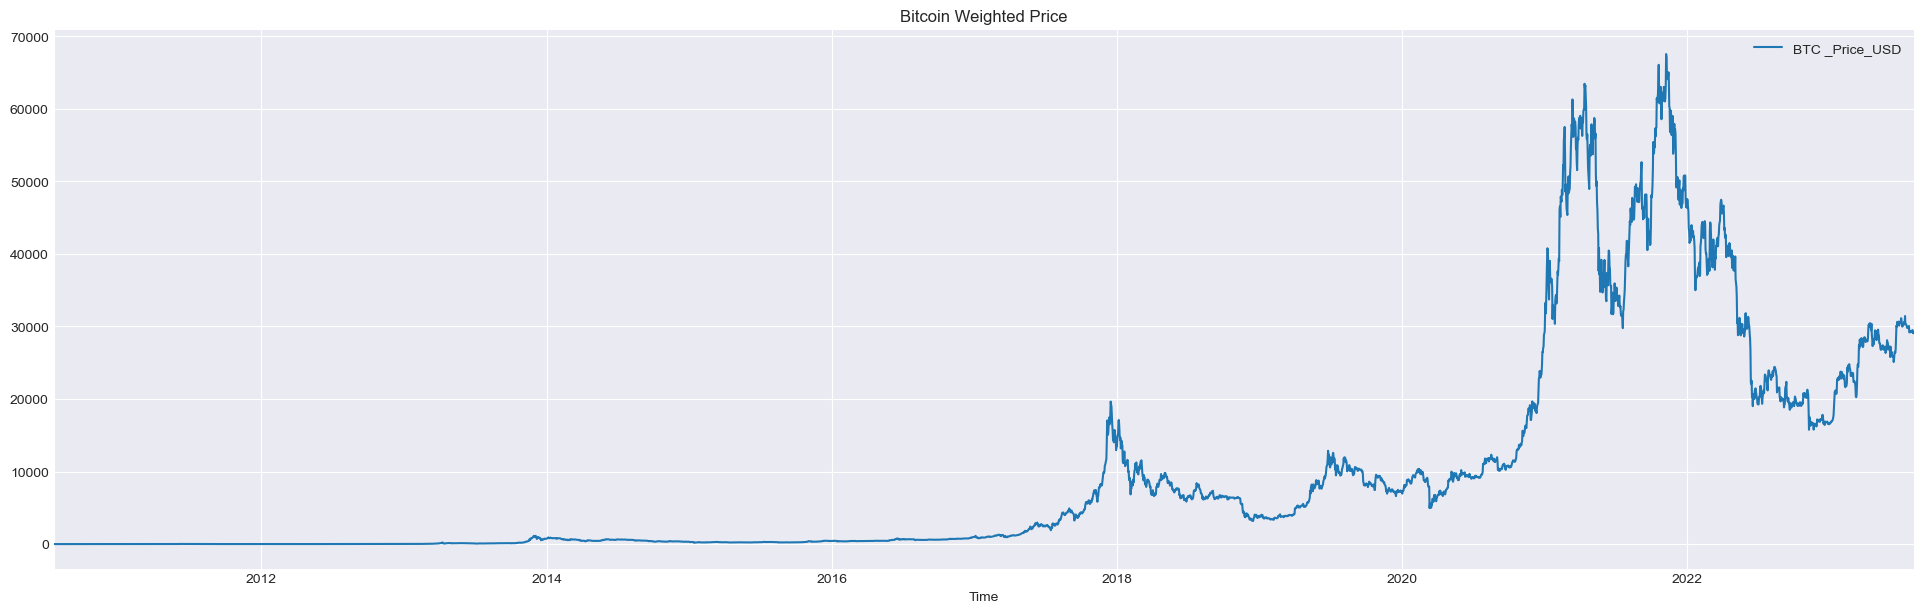

In [9]:
btc_input_df_datetype.set_index("Time").plot(figsize=(24,7), title="Bitcoin Weighted Price")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


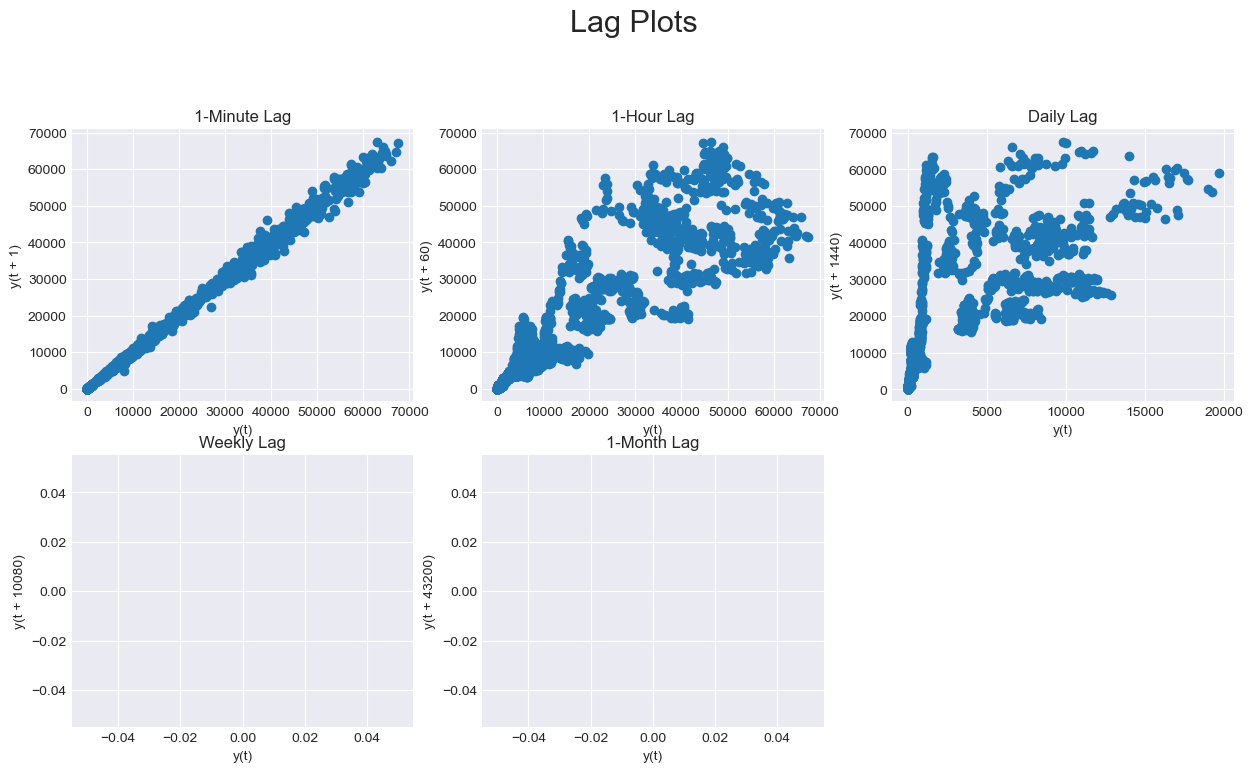

In [10]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['BTC _Price_USD'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['BTC _Price_USD'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['BTC _Price_USD'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['BTC _Price_USD'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['BTC _Price_USD'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [11]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['Time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['BTC _Price_USD'].mean()

,Time,BTC _Price_USD,date
0,2010-07-18,0.085840,2010-07-18
1,2010-07-19,0.080800,2010-07-19
2,2010-07-20,0.074736,2010-07-20
3,2010-07-21,0.079193,2010-07-21
4,2010-07-22,0.058470,2010-07-22


In [12]:
display(btc_closing_price_groupby_date.head(10))

print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

date
2010-07-18    0.085840
2010-07-19    0.080800
2010-07-20    0.074736
2010-07-21    0.079193
2010-07-22    0.058470
2010-07-23    0.060593
2010-07-24    0.054540
2010-07-25    0.050541
2010-07-26    0.056000
2010-07-27    0.058622
Name: BTC _Price_USD, dtype: float64

Length of btc_closing_price_groupby_date : 4766


# Data Split into TRAIN AND TEST

In [13]:
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [14]:
df_test.shape

(60, 1)

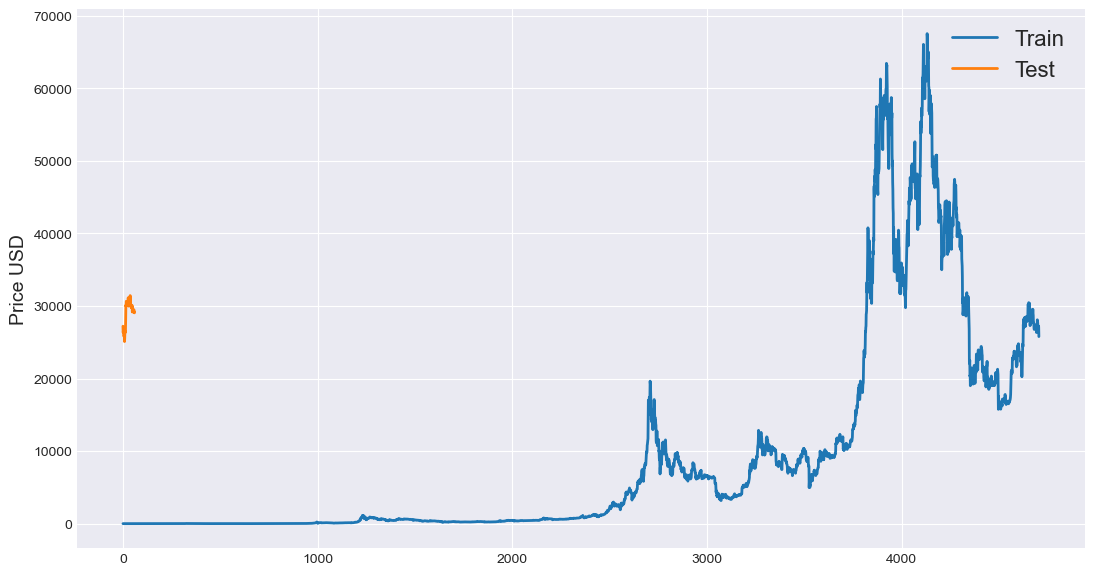

In [15]:
chosen_col = 'BTC _ Price_USD'

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

# Data Scaling

In [16]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)
scaled_train

array([[5.22630899e-07],
       [4.48010337e-07],
       [3.58224759e-07],
       ...,
       [4.00927959e-01],
       [4.02095328e-01],
       [3.81775985e-01]])

In [17]:
scaled_test

array([[0.33393325],
       [0.19598615],
       [0.22472376],
       [0.21667345],
       [0.1208159 ],
       [0.12769822],
       [0.12768619],
       [0.12360045],
       [0.        ],
       [0.07283368],
       [0.19476179],
       [0.22353676],
       [0.19825589],
       [0.26517883],
       [0.50619522],
       [0.78930275],
       [0.76610556],
       [0.87433125],
       [0.86023383],
       [0.84736118],
       [0.813978  ],
       [0.87886366],
       [0.79001725],
       [0.84631223],
       [0.8500537 ],
       [0.86538957],
       [0.8673664 ],
       [0.95275828],
       [0.89983068],
       [0.85215541],
       [0.77040063],
       [0.82565468],
       [0.81519834],
       [0.79935548],
       [0.83587577],
       [0.87084283],
       [0.83444819],
       [1.        ],
       [0.82262319],
       [0.81950169],
       [0.81301334],
       [0.79628237],
       [0.74768026],
       [0.75987534],
       [0.74292405],
       [0.76092692],
       [0.73036368],
       [0.784

# Data Window Size

In [18]:
def dataset_generator_lstm(dataset, look_back=5):
    
    """
    Generates input-output pairs for an LSTM dataset.
    
    Args:
        dataset (numpy.ndarray): The dataset to generate input-output pairs from.
        look_back (int): The number of previous timesteps to use for prediction.
    
    Returns:
        numpy.ndarray: The input sequences.
        numpy.ndarray: The corresponding output values.
    """
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    
    # Iterate over the dataset, considering a "look_back" window of previous timesteps
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (4701, 5)
trainY:  (4701,)
testX:  (55, 5)
testY (55,)


In [20]:
print("trainX: ", trainX)
print("trainY: ", trainY)
print("testY: ", testX)
print("testY", testY)

trainX:  [[5.22630899e-07 4.48010337e-07 3.58224759e-07 4.24215602e-07
  1.17396237e-07]
 [4.48010337e-07 3.58224759e-07 4.24215602e-07 1.17396237e-07
  1.48830297e-07]
 [3.58224759e-07 4.24215602e-07 1.17396237e-07 1.48830297e-07
  5.92135185e-08]
 ...
 [4.11079678e-01 4.10301177e-01 4.02975210e-01 3.97166770e-01
  4.03531084e-01]
 [4.10301177e-01 4.02975210e-01 3.97166770e-01 4.03531084e-01
  4.00927959e-01]
 [4.02975210e-01 3.97166770e-01 4.03531084e-01 4.00927959e-01
  4.02095328e-01]]
trainY:  [1.48830297e-07 5.92135185e-08 0.00000000e+00 ... 4.00927959e-01
 4.02095328e-01 3.81775985e-01]
testY:  [[0.33393325 0.19598615 0.22472376 0.21667345 0.1208159 ]
 [0.19598615 0.22472376 0.21667345 0.1208159  0.12769822]
 [0.22472376 0.21667345 0.1208159  0.12769822 0.12768619]
 [0.21667345 0.1208159  0.12769822 0.12768619 0.12360045]
 [0.1208159  0.12769822 0.12768619 0.12360045 0.        ]
 [0.12769822 0.12768619 0.12360045 0.         0.07283368]
 [0.12768619 0.12360045 0.         0.072833

In [21]:
print(trainX.shape)
print(testX.shape)

(4701, 5)
(55, 5)


In [22]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (4701, 5, 1)
Shape of testX:  (55, 5, 1)


In [23]:
print("trainX: ", trainX)
print(" ********** ")
print("testX: ", testX)

trainX:  [[[5.22630899e-07]
  [4.48010337e-07]
  [3.58224759e-07]
  [4.24215602e-07]
  [1.17396237e-07]]

 [[4.48010337e-07]
  [3.58224759e-07]
  [4.24215602e-07]
  [1.17396237e-07]
  [1.48830297e-07]]

 [[3.58224759e-07]
  [4.24215602e-07]
  [1.17396237e-07]
  [1.48830297e-07]
  [5.92135185e-08]]

 ...

 [[4.11079678e-01]
  [4.10301177e-01]
  [4.02975210e-01]
  [3.97166770e-01]
  [4.03531084e-01]]

 [[4.10301177e-01]
  [4.02975210e-01]
  [3.97166770e-01]
  [4.03531084e-01]
  [4.00927959e-01]]

 [[4.02975210e-01]
  [3.97166770e-01]
  [4.03531084e-01]
  [4.00927959e-01]
  [4.02095328e-01]]]
 ********** 
testX:  [[[0.33393325]
  [0.19598615]
  [0.22472376]
  [0.21667345]
  [0.1208159 ]]

 [[0.19598615]
  [0.22472376]
  [0.21667345]
  [0.1208159 ]
  [0.12769822]]

 [[0.22472376]
  [0.21667345]
  [0.1208159 ]
  [0.12769822]
  [0.12768619]]

 [[0.21667345]
  [0.1208159 ]
  [0.12769822]
  [0.12768619]
  [0.12360045]]

 [[0.1208159 ]
  [0.12769822]
  [0.12768619]
  [0.12360045]
  [0.        ]

In [24]:
print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


# Model IMPLEMENTING

In [25]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, return_sequences=True,input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 64)             33024     
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
147/147 [==============================] - ETA: 0s - loss: 0.0095
Epoch 1: val_loss improved from inf to 0.26547, saving model to my_best_model.hdf5
147/147 [==============================] - 40s 51ms/step - loss: 0.0095 - val_loss: 0.2655
Epoch 2/600
146/147 [============================>.] - ETA: 0s - loss: 0.0256
Epoch 2: val_loss improved from 0.26547 to 0.22883, saving model to my_best_model.hdf5
147/147 [==============================] - 4s 27ms/step - loss: 0.0256 - val_loss: 0.2288
Epoch 3/600
147/147 [==============================] - ETA: 0s - loss: 0.0377
Epoch 3: val_loss improved from 0.22883 to 0.14265, saving model to my_best_model.hdf5
147/147 [==============================] - 4s 28ms/step - loss: 0.0377 - val_loss: 0.1427
Epoch 4/600
145/147 [============================>.] - ETA: 0s - loss: 0.0475
Epoch 4: val_loss did not improve from 0.14265
147/147 [==============================] - 3s 23ms/step - loss: 0.0470 - val_loss: 0.1799
Epoch 5/600
146/147 [==

146/147 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 37: val_loss did not improve from 0.02760
147/147 [==============================] - 3s 22ms/step - loss: 0.0026 - val_loss: 0.0348
Epoch 38/600
146/147 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 38: val_loss did not improve from 0.02760
147/147 [==============================] - 3s 24ms/step - loss: 0.0023 - val_loss: 0.0417
Epoch 39/600
145/147 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 39: val_loss did not improve from 0.02760
147/147 [==============================] - 4s 25ms/step - loss: 0.0025 - val_loss: 0.0289
Epoch 40/600
145/147 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 40: val_loss did not improve from 0.02760
147/147 [==============================] - 3s 24ms/step - loss: 0.0017 - val_loss: 0.0315
Epoch 41/600
145/147 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 41: val_loss improved from 0.02760 to 0.02714, saving model 

In [27]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)
print(model_from_saved_checkpoint)

# CHECK TRAIN LOSS AND TEST LOLSS

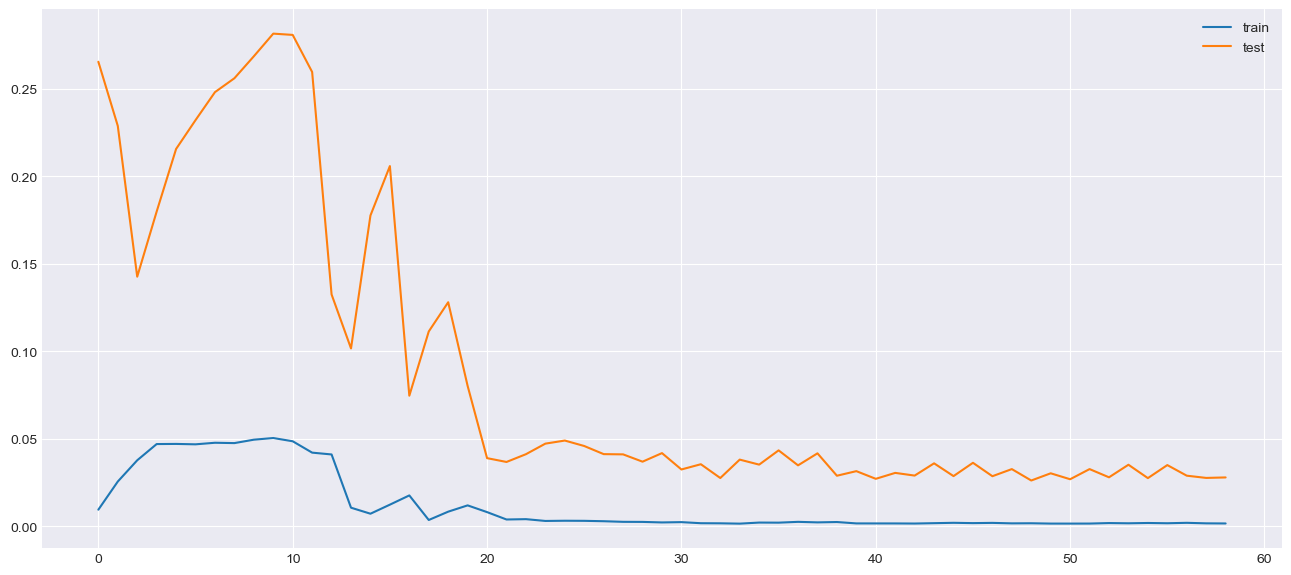

In [28]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# PREDICTING OF TEST DATA

In [29]:
# Transformation to original form and making the predictions

#predicted_btc_price_test_data = regressor.predict(testX)
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
#print(predicted_btc_price_test_data)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
print(predicted_btc_price_test_data)
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))
#print(predicted_btc_price_test_d---------ata)


2/2 [==============================] - 20s 22ms/step
[[26540.248]
 [26208.13 ]
 [26026.02 ]
 [25834.969]
 [25747.582]
 [25725.533]
 [25660.686]
 [25582.012]
 [25521.395]
 [25896.049]
 [26520.371]
 [27082.3  ]
 [27571.383]
 [28142.812]
 [29040.646]
 [30054.271]
 [30180.63 ]
 [30387.379]
 [30320.566]
 [30263.584]
 [30222.025]
 [30301.434]
 [30229.572]
 [30414.693]
 [30452.979]
 [30477.576]
 [30466.564]
 [30457.033]
 [30292.318]
 [30093.715]
 [29946.043]
 [30144.82 ]
 [30159.041]
 [30292.564]
 [30401.623]
 [30434.12 ]
 [30399.977]
 [30409.936]
 [30039.084]
 [29913.564]
 [29724.564]
 [29514.354]
 [29323.975]
 [29354.521]
 [29245.186]
 [29130.244]
 [28896.975]
 [28733.84 ]
 [28517.414]
 [28541.643]
 [28554.604]
 [28537.291]
 [28568.361]
 [28560.127]
 [28537.457]]


In [30]:
print(test_actual)

[[25906.82815]
 [25906.75194]
 [25880.85997]
 [25097.58538]
 [25559.14333]
 [26331.82009]
 [26514.17135]
 [26353.96268]
 [26778.06344]
 [28305.42046]
 [30099.51535]
 [29952.51129]
 [30638.35376]
 [30549.01629]
 [30467.44037]
 [30255.88612]
 [30667.07629]
 [30104.04327]
 [30460.79298]
 [30484.50326]
 [30581.68897]
 [30594.21647]
 [31135.3576 ]
 [30799.94746]
 [30497.82213]
 [29979.72981]
 [30329.88298]
 [30263.61963]
 [30163.22106]
 [30394.65558]
 [30616.24709]
 [30385.60879]
 [31434.73547]
 [30310.67202]
 [30290.8906 ]
 [30249.77297]
 [30143.74627]
 [29835.74741]
 [29913.02946]
 [29805.60657]
 [29919.69349]
 [29726.00963]
 [30066.57245]
 [29178.3597 ]
 [29221.25485]
 [29361.59176]
 [29201.68652]
 [29316.31308]
 [29360.37618]
 [29262.83673]
 [29219.82019]
 [29499.58754]
 [29143.15196]
 [29192.34486]
 [29057.25324]]


# GRAPH BETWEEN PREDICTED TEST AND ACTUAL TEST

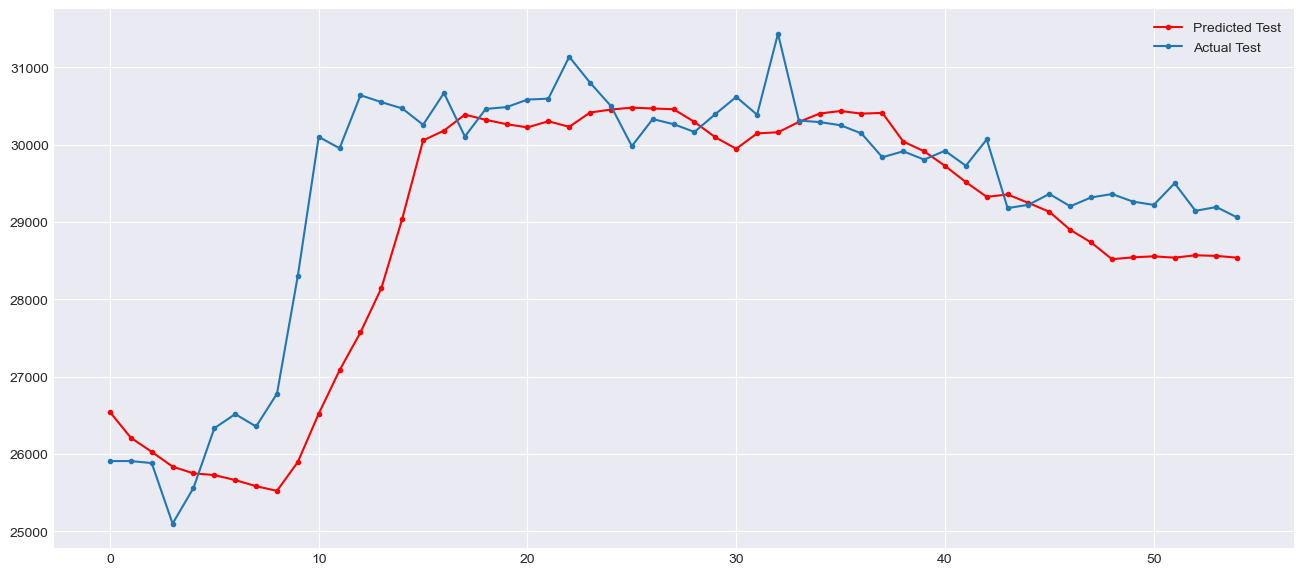

In [31]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [32]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

147/147 [==============================] - 1s 9ms/step


# GRAPH BETWEEN PREDICTED TRAIN AND ACTUAL TRAIN

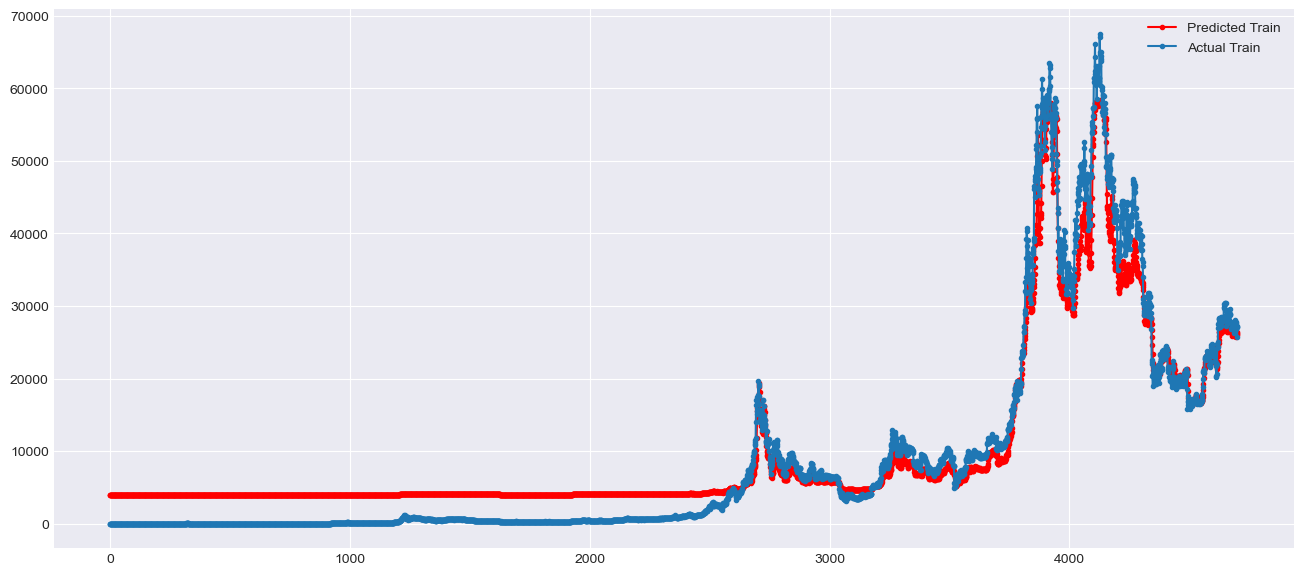

In [33]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


# Assuming you have `test_actual` and `predicted_btc_price_test_data` arrays

mae_lstm_test = mean_absolute_error(test_actual, predicted_btc_price_test_data)

print('Test MAE: %.3f' % mae_lstm_test)

# Assuming you have `test_actual` and `predicted_btc_price_test_data` arrays

mse_lstm_test = mean_squared_error(test_actual, predicted_btc_price_test_data)

print('Test MSE: %.3f' % mse_lstm_test)

from sklearn.metrics import r2_score

r2_lstm_test = r2_score(test_actual, predicted_btc_price_test_data)
print('Test R-squared: %.3f' % r2_lstm_test)




# Assuming you have `test_actual` and `predicted_btc_price_test_data` arrays

# Calculate Mean Absolute Percentage Error (MAPE)
mape_lstm_test = np.mean(np.abs((test_actual - predicted_btc_price_test_data) / test_actual)) * 100

print('Test MAPE: %.3f%%' % mape_lstm_test)


accuracy = 100 - mape_lstm_test

print('Test Accuaracy : %.3f%%'%accuracy)


Test RMSE: 1025.379
Test MAE: 668.773
Test MSE: 1051401.563
Test R-squared: 0.583
Test MAPE: 2.278%
Test Accuaracy : 97.722%


In [58]:
predicted_testY

array([[0.22080275],
       [0.16734165],
       [0.14321205],
       [0.11477905],
       [0.09737988],
       [0.09456915],
       [0.08635752],
       [0.07697572],
       [0.06925146],
       [0.11354087],
       [0.21309529],
       [0.3213539 ],
       [0.4220482 ],
       [0.5345356 ],
       [0.6689099 ],
       [0.79826945],
       [0.81689125],
       [0.83699435],
       [0.83097845],
       [0.82493323],
       [0.8227371 ],
       [0.82885516],
       [0.8211302 ],
       [0.83867013],
       [0.841263  ],
       [0.8425895 ],
       [0.8423509 ],
       [0.8430899 ],
       [0.8295843 ],
       [0.8056837 ],
       [0.78880996],
       [0.8143756 ],
       [0.813685  ],
       [0.82780063],
       [0.83829004],
       [0.8401497 ],
       [0.83978266],
       [0.84131783],
       [0.80239964],
       [0.78569573],
       [0.75690156],
       [0.72195035],
       [0.69701785],
       [0.6998045 ],
       [0.6842223 ],
       [0.65714365],
       [0.6192497 ],
       [0.596

In [59]:
# Assuming you have `test_actual` and `predicted_btc_price_test_data` arrays

# Calculate Mean Squared Error (MSE) manually
squared_errors = [(actual - pred) ** 2 for actual, pred in zip(test_actual, predicted_btc_price_test_data)]
mse_lstm_test = sum(squared_errors) / len(squared_errors)

print('Test MSE: %.3f' % mse_lstm_test)


Test MSE: 940611.161


In [60]:
len(predicted_btc_price_test_data)



55

In [61]:
len(test_actual)

55

In [62]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)
mae_lstm_train = mean_absolute_error(train_actual, predicted_btc_price_train_data)

print('Test MAE: %.3f' % mae_lstm_train)

Test RMSE: 3422.523
Test MAE: 3038.769


In [63]:
len(predicted_btc_price_train_data)

4701

In [64]:
testX
testX.shape

(55, 5, 1)

In [65]:
print(testX)

[[[0.33393325]
  [0.19598615]
  [0.22472376]
  [0.21667345]
  [0.1208159 ]]

 [[0.19598615]
  [0.22472376]
  [0.21667345]
  [0.1208159 ]
  [0.12769822]]

 [[0.22472376]
  [0.21667345]
  [0.1208159 ]
  [0.12769822]
  [0.12768619]]

 [[0.21667345]
  [0.1208159 ]
  [0.12769822]
  [0.12768619]
  [0.12360045]]

 [[0.1208159 ]
  [0.12769822]
  [0.12768619]
  [0.12360045]
  [0.        ]]

 [[0.12769822]
  [0.12768619]
  [0.12360045]
  [0.        ]
  [0.07283368]]

 [[0.12768619]
  [0.12360045]
  [0.        ]
  [0.07283368]
  [0.19476179]]

 [[0.12360045]
  [0.        ]
  [0.07283368]
  [0.19476179]
  [0.22353676]]

 [[0.        ]
  [0.07283368]
  [0.19476179]
  [0.22353676]
  [0.19825589]]

 [[0.07283368]
  [0.19476179]
  [0.22353676]
  [0.19825589]
  [0.26517883]]

 [[0.19476179]
  [0.22353676]
  [0.19825589]
  [0.26517883]
  [0.50619522]]

 [[0.22353676]
  [0.19825589]
  [0.26517883]
  [0.50619522]
  [0.78930275]]

 [[0.19825589]
  [0.26517883]
  [0.50619522]
  [0.78930275]
  [0.76610556]]


In [66]:
testX.shape[0]

55

# Forecasting Values

In [36]:
lookback_period = 7

# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast for Future 5 days beyond 30-Oct-2021

testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]

testX_last_5_days.shape


(7, 5, 1)

In [37]:
testX_last_5_days

array([[[0.64394472],
        [0.65071356],
        [0.67285867],
        [0.64762568],
        [0.66571371]],

       [[0.65071356],
        [0.67285867],
        [0.64762568],
        [0.66571371],
        [0.67266685]],

       [[0.67285867],
        [0.64762568],
        [0.66571371],
        [0.67266685],
        [0.65727516]],

       [[0.64762568],
        [0.66571371],
        [0.67266685],
        [0.65727516],
        [0.65048717]],

       [[0.66571371],
        [0.67266685],
        [0.65727516],
        [0.65048717],
        [0.69463435]],

       [[0.67266685],
        [0.65727516],
        [0.65048717],
        [0.69463435],
        [0.63838895]],

       [[0.65727516],
        [0.65048717],
        [0.69463435],
        [0.63838895],
        [0.64615157]]])

In [70]:
print(scaler_test)

MinMaxScaler()


In [38]:
predicted_5_days_forecast_price_test_x = []

for i in range(7):  
  predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])
  #print(predicted_forecast_price_test_x)
  predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
  print(predicted_forecast_price_test_x)
  predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
  
print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x)) 
# That is the original Trading data ended on 30-Oct-2021, but now I am going to forecast beyond 30-Oct-2021

1/1 [==============================] - 0s 113ms/step
[[28517.414]]
1/1 [==============================] - 0s 26ms/step
[[28541.64]]
1/1 [==============================] - 0s 26ms/step
[[28554.604]]
1/1 [==============================] - 0s 37ms/step
[[28537.291]]
1/1 [==============================] - 0s 24ms/step
[[28568.361]]
1/1 [==============================] - 0s 45ms/step
[[28560.127]]
1/1 [==============================] - 0s 32ms/step
[[28537.455]]
Forecast for the next 5 Days Beyond the actual trading days  [[[28517.414]]

 [[28541.64 ]]

 [[28554.604]]

 [[28537.291]]

 [[28568.361]]

 [[28560.127]]

 [[28537.455]]]


In [39]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)

predicted_5_days_forecast_price_test_x.shape

(7, 1, 1)

In [40]:
predicted_btc_price_test_data.shape

(55, 1)

In [74]:
predicted_btc_price_test_data

array([[26496.848],
       [26158.057],
       [26005.14 ],
       [25824.959],
       [25714.695],
       [25696.885],
       [25644.844],
       [25585.39 ],
       [25536.441],
       [25817.111],
       [26448.002],
       [27134.055],
       [27772.168],
       [28485.018],
       [29336.566],
       [30156.338],
       [30274.348],
       [30401.744],
       [30363.621],
       [30325.31 ],
       [30311.393],
       [30350.166],
       [30301.213],
       [30412.363],
       [30428.795],
       [30437.201],
       [30435.691],
       [30440.371],
       [30354.785],
       [30203.324],
       [30096.393],
       [30258.406],
       [30254.03 ],
       [30343.48 ],
       [30409.955],
       [30421.74 ],
       [30419.416],
       [30429.143],
       [30182.514],
       [30076.656],
       [29894.184],
       [29672.691],
       [29514.691],
       [29532.352],
       [29433.605],
       [29262.004],
       [29021.863],
       [28879.361],
       [28762.535],
       [28782.344],


In [75]:
predicted_5_days_forecast_price_test_x

array([[[28762.535]],

       [[28782.344]],

       [[28795.941]],

       [[28781.322]],

       [[28806.436]],

       [[28796.752]],

       [[28776.877]]], dtype=float32)

In [41]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()

predicted_5_days_forecast_price_test_x

array([28517.414, 28541.64 , 28554.604, 28537.291, 28568.361, 28560.127,
       28537.455], dtype=float32)

In [42]:
predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()

predicted_btc_price_test_data

array([26540.248, 26208.13 , 26026.02 , 25834.969, 25747.582, 25725.533,
       25660.686, 25582.012, 25521.395, 25896.049, 26520.371, 27082.3  ,
       27571.383, 28142.812, 29040.646, 30054.271, 30180.63 , 30387.379,
       30320.566, 30263.584, 30222.025, 30301.434, 30229.572, 30414.693,
       30452.979, 30477.576, 30466.564, 30457.033, 30292.318, 30093.715,
       29946.043, 30144.82 , 30159.041, 30292.564, 30401.623, 30434.12 ,
       30399.977, 30409.936, 30039.084, 29913.564, 29724.564, 29514.354,
       29323.975, 29354.521, 29245.186, 29130.244, 28896.975, 28733.84 ,
       28517.414, 28541.643, 28554.604, 28537.291, 28568.361, 28560.127,
       28537.457], dtype=float32)

In [43]:
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_5_days_forecast_price_test_x))

predicted_btc_test_concatenated

predicted_btc_test_concatenated.shape

(62,)

# ACTUAL DATA AND 7 DAYS FUTURES VALUES

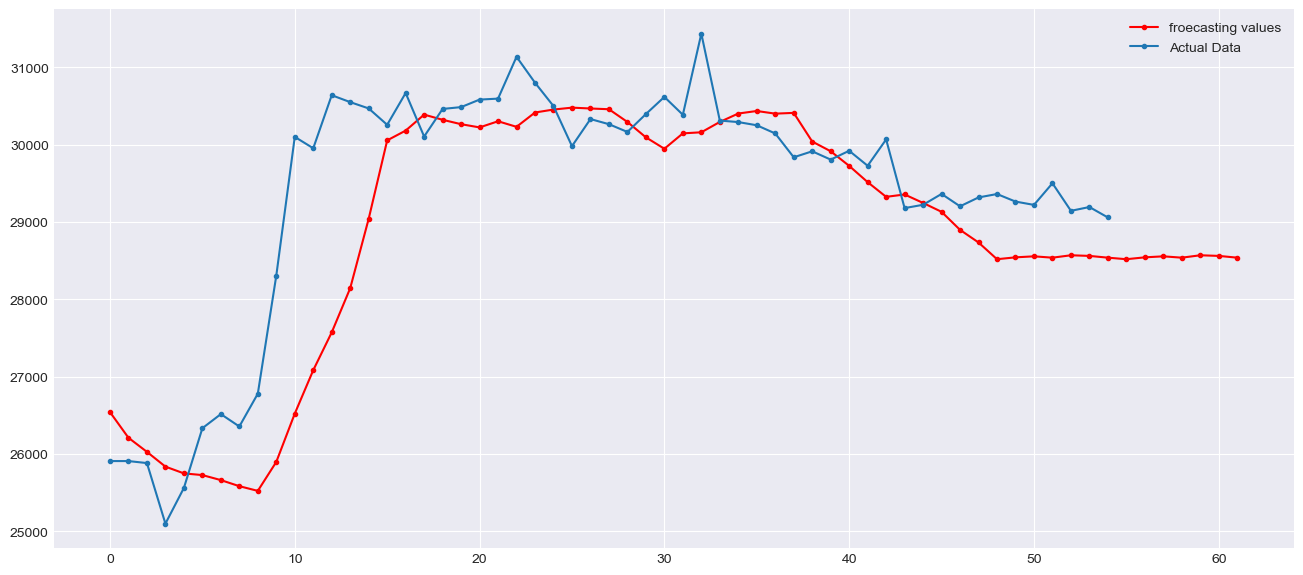

In [45]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='froecasting values')

plt.plot(test_actual, marker='.', label='Actual Data')

plt.legend()

plt.show()